In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

In [18]:
memory=MemorySaver()

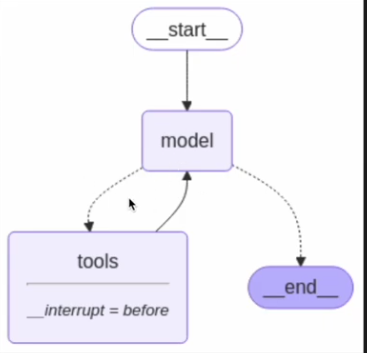

In [2]:
search_tool=TavilySearchResults(max_results=2)

In [3]:
tools=[search_tool]

In [4]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [5]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [6]:
class BasicState(TypedDict):
    messages:Annotated[List, add_messages]

In [7]:
def model(state:BasicState):
    return {
        "messages":[llm_with_tools.invoke(input=state["messages"])]
    }

In [9]:
def tools_router(state: BasicState):
    last_message=state['messages'][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tools"
    else:
        return "end"

In [10]:
graph=StateGraph(BasicState)

In [11]:
graph.add_node(node="model",action=model)

In [12]:
graph.add_node(node="tools",action=ToolNode(tools=tools))

In [13]:
graph.add_conditional_edges(
    source="model",
    path=tools_router,
    path_map={
            "tools":"tools",
            "end":END
            })

In [14]:
graph.add_edge(start_key="tools",end_key="model")

In [15]:
graph.set_entry_point(key="model")

In [19]:
app=graph.compile(checkpointer=memory, interrupt_before=["tools"])

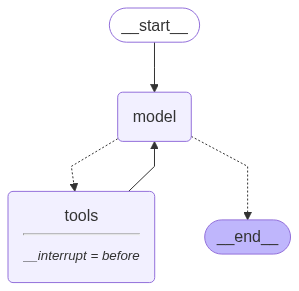

In [20]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [21]:
app.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
          +-------+           
          | model |           
          +-------+           
         .         .          
       ..           ..        
      .               .       
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


In [49]:
config={
    "configurable":{
        "thread_id": 3
    }
}

In [50]:
events=app.stream(input={
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

In [51]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("\n")


[HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='6f941ebf-6c2c-461c-98e4-79391631a437')]
content='What is the current weather in Chennai?' additional_kwargs={} response_metadata={} id='6f941ebf-6c2c-461c-98e4-79391631a437' 

================================ Human Message =================================

What is the current weather in Chennai?


[HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='6f941ebf-6c2c-461c-98e4-79391631a437'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_93a6', 'function': {'arguments': '{"query": "Current weather in Chennai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.019092453, 'queue_time': 0.063222657, 'total_time': 0.047092453}, 'model_name': '

In [52]:
snapshot=app.get_state(config=config)

In [53]:
snapshot.next

('tools',)

In [55]:
events=app.stream(input=None, config=config, stream_mode="values")

In [56]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("\n")

[HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='6f941ebf-6c2c-461c-98e4-79391631a437'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_93a6', 'function': {'arguments': '{"query": "Current weather in Chennai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.019092453, 'queue_time': 0.063222657, 'total_time': 0.047092453}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a029cb77-ff55-4eb9-b18d-9f7eb287dfd4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in Chennai'}, 'id': 'call_93a6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]
content='' additional_kwargs=